# CLASSIFICATION

### CLASSIFICATION PLAN:
We collected the labelled data from 2 different origins:
1. **KMeans Clustering** result (which will be called **original data**): 3 distinct classes, one of which is highly **imbalanced**
2. **Fuzzy Kmeans Clustering** result (which will be called **fuzzy data**): 3 distinct classes, not on same magnitude but also not particularly imbalanced

Different approaches will be evaluated:
* Apply classification on original training set i.e. high imbalance in data
* Apply classification on oversampled original training set (robust oversampling method -> SMOTE)
* Apply classification on oversampled original training set and test set (robust oversampling method -> SMOTE)
* Apply classification on fuzzy training set i.e. more balanced data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus

from tqdm.notebook import tqdm
from IPython.display import Image 
from collections import Counter
from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

***

In [2]:
# UTILITY FUNCTIONS

# transform categorical attributes in numerical 
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

# pretty printing of metrics computed on test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes, zero_division=0)) 
# (to avoid exagerated warnings) zero division = 0 makes sure that no warnings 
# are raised even if no classification on a certain class happens (and it can happen in multiple cases in this notebook)

***

# WORKING ON ORIGINAL DATA

***

In [3]:
# Starting dataset
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MeanTimeGap     4333 non-null   float64
 13  MaxOrderMonth   4333 non-null   object 
 14  MaxOrderDay     4333 non-null   object 
 15  Label           4333 non-null   object 
dtypes: float64(9), int64(4), object(3)
memory usage: 575.5+ KB


In [4]:
# taking a look at data distribution between classes
for label in df['Label'].unique():
    print(label,"elements in dataset:",len(df[df['Label'] == label]))

Low_Spend elements in dataset: 3867
Med_Spend elements in dataset: 440
High_Spend elements in dataset: 26


In [5]:
# we only have 2 categorical attributes, discretize them and get rid of them 
# (also get rid of attributes which lead in our experiments to bad classification)
df = discretize_data(df,['MaxOrderMonth','MaxOrderDay','Label'])
df.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,MeanTimeGap,MaxOrderMonth_num,MaxOrderDay_num,Label_num
CustomerID,,,,,,,,,,,,
13436,76,12,76.0,196.89,196.89,0,5.830,1,0.0,2,3,1
15520,314,18,314.0,343.50,343.50,0,1.724,1,0.0,2,3,1
13298,96,2,96.0,360.00,360.00,0,3.750,1,0.0,2,3,1
14569,79,10,79.0,227.39,227.39,0,3.920,1,0.0,2,3,1
12713,505,37,505.0,794.55,794.55,0,2.085,1,0.0,2,0,2


In [6]:
# we keep true labels apart
label = df_class.pop('Label_num')
# we split dataset in training and test dataset. The use of stratify assures we keep correct class proportions in training and test
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify = label, test_size=0.30)

***

## CLASSIFICATION on ORIGINAL TRAINING SET

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [7]:
# parameters based on various trial and errors
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

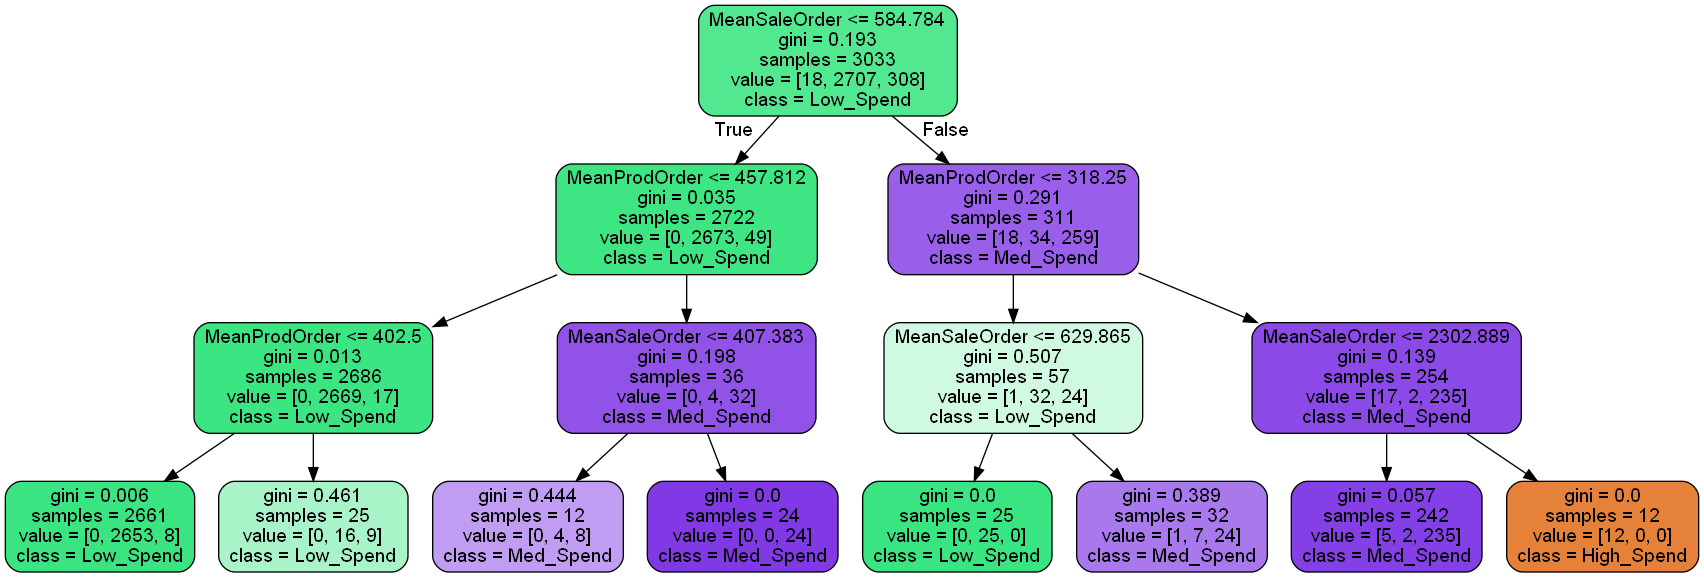

In [8]:
# visualization of dt 
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [9]:
# predict and evaluate results on training and test set
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

print('Accuracy training set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision training set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall training set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score trainig set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support training set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy training set  0.9881305637982196
Accuracy test set  0.9869230769230769
Precision training set  0.988179249469293
Recall training set  0.9881305637982196
F1 score trainig set  0.9879555973044198
Support training set  (array([1.        , 0.99372925, 0.93870968]), array([0.66666667, 0.99519764, 0.94480519]), array([0.8       , 0.9944629 , 0.94174757]), array([  18, 2707,  308], dtype=int64))


In [10]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.78      0.88      0.82         8
   Low_Spend       0.99      0.99      0.99      1160
   Med_Spend       0.93      0.94      0.94       132

    accuracy                           0.99      1300
   macro avg       0.90      0.94      0.92      1300
weighted avg       0.99      0.99      0.99      1300



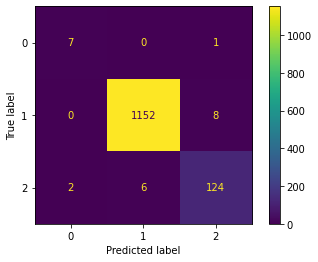

In [11]:
# plot confusion matrix
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

### Random Forest

**First do a grid search for correct parameter setting**

In [12]:
# define the parameter ranges we want to try, then run the grid search
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=num_estimators)
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67B2D9F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D3E4160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D374970>},
                   scoring=make_scorer(accuracy_score))

In [13]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 13, 'min_samples_split': 3}
Mean and std of this setting  0.9861543815007531 0.006300067523492368


In [14]:
# set and training the specified random forest
rf = RandomForestClassifier(n_estimators=30, 
                             criterion=grid_search.cv_results_['params'][0]['criterion'],
                             max_features=grid_search.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search.cv_results_['params'][0]['bootstrap']) 
rf = rf.fit(train_set, train_label)

In [15]:
# predict on test and visualize results
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.75      0.86         8
   Low_Spend       1.00      0.99      0.99      1160
   Med_Spend       0.93      0.97      0.95       132

    accuracy                           0.99      1300
   macro avg       0.97      0.90      0.93      1300
weighted avg       0.99      0.99      0.99      1300



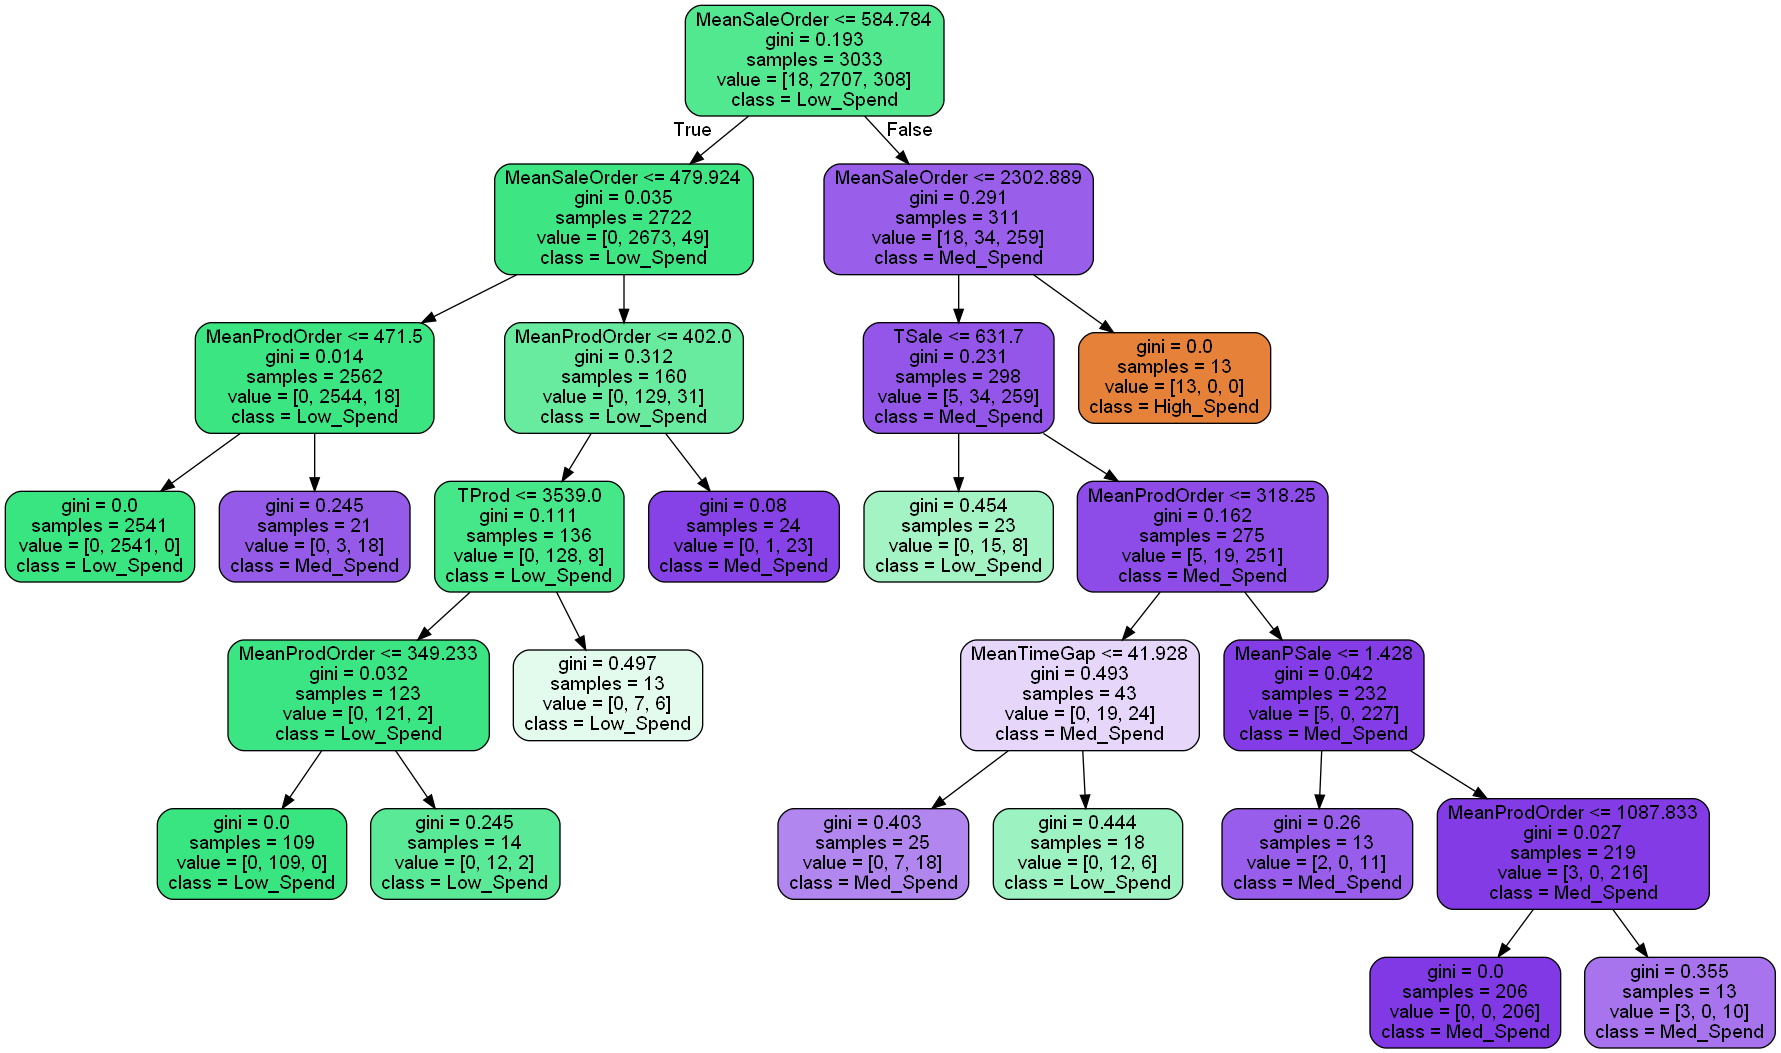

In [16]:
# forest is composed of lots of dt, visualize one just for fun
dot_data = tree.export_graphviz(rf[0], out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Naive Bayes

In [17]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.47      0.88      0.61         8
   Low_Spend       0.98      0.96      0.97      1160
   Med_Spend       0.71      0.82      0.76       132

    accuracy                           0.94      1300
   macro avg       0.72      0.88      0.78      1300
weighted avg       0.95      0.94      0.95      1300



### KNN

In [18]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.50      0.67         8
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.89      0.83      0.86       132

    accuracy                           0.97      1300
   macro avg       0.96      0.78      0.84      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [19]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.91      1.00      0.95      1160
   Med_Spend       0.70      0.16      0.26       132

    accuracy                           0.91      1300
   macro avg       0.54      0.39      0.40      1300
weighted avg       0.88      0.91      0.88      1300



***

## CLASSIFICATION on OVERSAMPLED TRAINING SET (SMOTE)

**SMOTE** is a different stratification method which applies oversampling to the classes. The difference between this method and the basic oversampling stands in the generation of new data:
* in the basic oversampling, original data is simply copied to create exact (but additional) new data
* in SMOTE oversampling, original data is used to create new data which copies the old one adding a [0,1] **perturbation**, hence generating truly new data

In [20]:
# create oversampled data
strat = {1: Counter(train_label)[1], 2: Counter(train_label)[2], 0: Counter(train_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)

train_set_smote, train_label_smote = smote.fit_resample(train_set, train_label)

In [21]:
# visualize data distribution
Counter(train_label_smote)

Counter({2: 308, 1: 2707, 0: 308})

### Random Forest

Try grid search again, on this more **balanced** dataset

In [22]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67B2D9F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D3E4160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D374970>},
                   scoring=make_scorer(accuracy_score))

In [23]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 17, 'min_samples_split': 15}
Mean and std of this setting  0.9858578675604674 0.006629793989340971


In [24]:
# set and training the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [25]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.67      1.00      0.80         8
   Low_Spend       1.00      0.99      0.99      1160
   Med_Spend       0.94      0.94      0.94       132

    accuracy                           0.99      1300
   macro avg       0.87      0.98      0.91      1300
weighted avg       0.99      0.99      0.99      1300



### Naive Bayes

In [26]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.44      0.88      0.58         8
   Low_Spend       0.98      0.96      0.97      1160
   Med_Spend       0.70      0.81      0.75       132

    accuracy                           0.94      1300
   macro avg       0.71      0.88      0.77      1300
weighted avg       0.95      0.94      0.95      1300



### KNN

In [27]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.57      1.00      0.73         8
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.93      0.80      0.86       132

    accuracy                           0.97      1300
   macro avg       0.83      0.93      0.86      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [28]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.07      0.75      0.12         8
   Low_Spend       0.91      0.95      0.93      1160
   Med_Spend       0.00      0.00      0.00       132

    accuracy                           0.85      1300
   macro avg       0.33      0.57      0.35      1300
weighted avg       0.81      0.85      0.83      1300



***

## CLASSIFICATION on OVERSAMPLED TRAINING SET and TEST SET (SMOTE)

In [29]:
# before starting classification we apply stratification to test set to have more data in less populated class
# we do this because otherwise our test set would be populated of < 10 elements for High_Spend class, giving a susceptible evaluation  
strat = {1: Counter(test_label)[1], 2: Counter(test_label)[2], 0: Counter(test_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)
test_set, test_label = smote.fit_resample(test_set, test_label)

# visualize data distribution in TEST
Counter(test_label)

Counter({1: 1160, 2: 132, 0: 132})

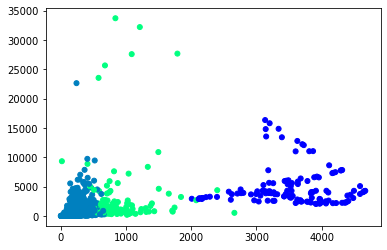

In [30]:
plt.scatter(test_set.iloc[:, 4].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

In [31]:
# visualize data distribution in TRAINING
Counter(train_label_smote)

Counter({2: 308, 1: 2707, 0: 308})

### Random Forest

Try grid search again, on this more balanced dataset

In [32]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67B2D9F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D3E4160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D374970>},
                   scoring=make_scorer(accuracy_score))

In [33]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 12}
Mean and std of this setting  0.9888681039949271 0.004098124012519128


In [34]:
# set and training the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [35]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.98      1.00      0.99       132
   Low_Spend       1.00      1.00      1.00      1160
   Med_Spend       0.97      0.95      0.96       132

    accuracy                           0.99      1424
   macro avg       0.98      0.98      0.98      1424
weighted avg       0.99      0.99      0.99      1424



### Naive Bayes

In [36]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.93      0.95      0.94       132
   Low_Spend       0.98      0.96      0.97      1160
   Med_Spend       0.68      0.81      0.74       132

    accuracy                           0.94      1424
   macro avg       0.86      0.91      0.88      1424
weighted avg       0.95      0.94      0.95      1424



### KNN

In [37]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.95      0.94      0.95       132
   Low_Spend       0.98      0.99      0.99      1160
   Med_Spend       0.88      0.80      0.83       132

    accuracy                           0.97      1424
   macro avg       0.94      0.91      0.92      1424
weighted avg       0.97      0.97      0.97      1424



### SVM

In [38]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.56      0.80      0.66       132
   Low_Spend       0.89      0.95      0.92      1160
   Med_Spend       0.00      0.00      0.00       132

    accuracy                           0.85      1424
   macro avg       0.48      0.58      0.53      1424
weighted avg       0.78      0.85      0.81      1424



***

# WORKING ON FUZZY DATA

In [39]:
# Starting dataset
df_f = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)

In [40]:
# we only have 2 categorical attributes, discretize them and get rid of them 
# (also get rid of attributes which lead in our experiments to bad classification)
df_f = discretize_data(df_f,['MaxOrderMonth','MaxOrderDay','Label'])
df_f.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df_f.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_f_class = df_f.copy()

In [41]:
# we keep true labels apart
label = df_f_class.pop('Label_num')
# we split dataset in training and test dataset. The use of stratify assures we keep correct class proportions in training and test
train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_f_class, label, stratify = label, test_size=0.30)

***

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [42]:
# parameters based on various trial and errors
dt_f = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt_f = dt_f.fit(train_set_f, train_label_f)

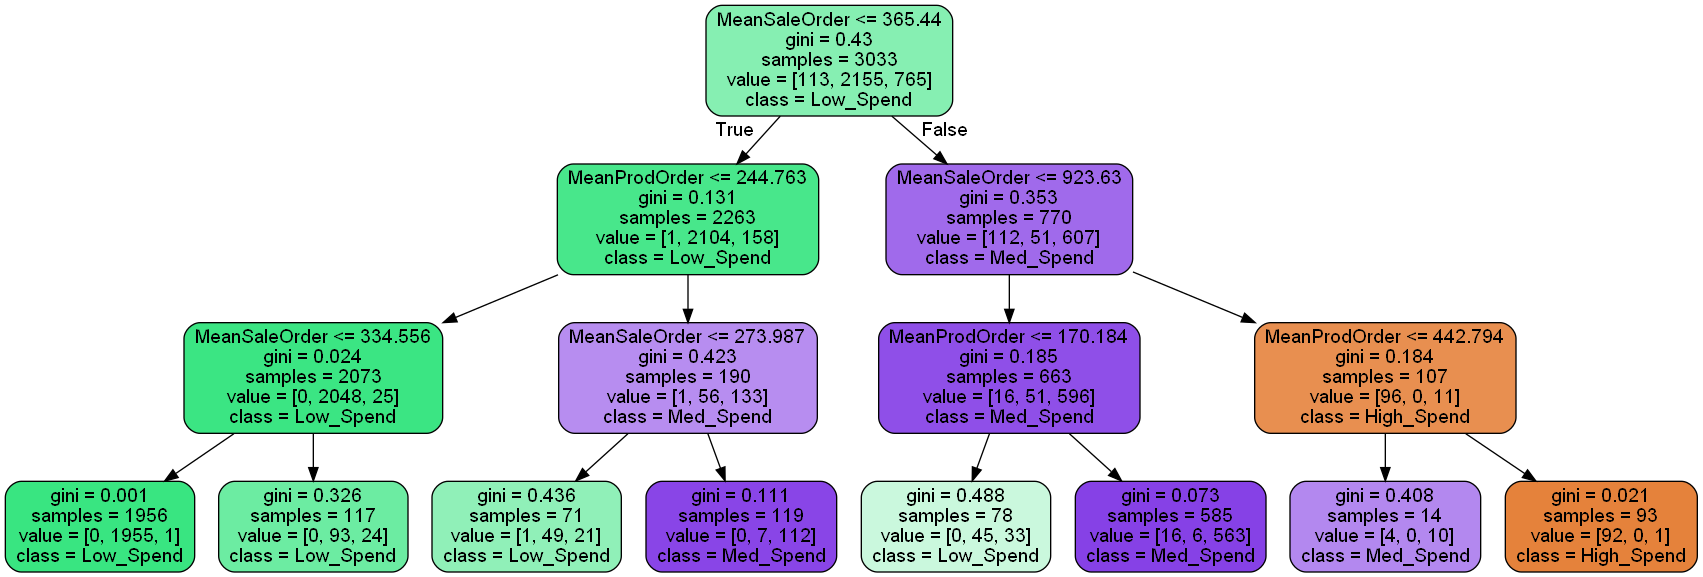

In [43]:
# visualization of dt
dot_data_f = tree.export_graphviz(dt_f, out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

In [44]:
# predict on training and test set
train_pred_dt_f = dt_f.predict(train_set_f)
test_pred_dt_f = dt_f.predict(test_set_f)

In [45]:
# visualize results
report_scores(test_label_f, test_pred_dt_f)

              precision    recall  f1-score   support

  High_Spend       0.98      0.88      0.92        49
   Low_Spend       0.96      0.99      0.97       923
   Med_Spend       0.95      0.88      0.91       328

    accuracy                           0.96      1300
   macro avg       0.96      0.91      0.94      1300
weighted avg       0.96      0.96      0.96      1300



### Random Forest

**Do a grid search for correct parameter setting**

In [46]:
# define the parameter ranges we want to try, then run the grid search
clf_f = RandomForestClassifier(n_estimators=30)
grid_search_f = RandomizedSearchCV(clf_f, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_f.fit(train_set_f, train_label_f)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67B2D9F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D3E4160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B67D374970>},
                   scoring=make_scorer(accuracy_score))

In [47]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_f.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_f.cv_results_['mean_test_score'][0], 
      grid_search_f.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 11, 'min_samples_split': 5}
Mean and std of this setting  0.9812071487214619 0.007113871719129021


In [48]:
# set and training the specified random forest
rf_f = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_f.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_f.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_f.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_f.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_f.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_f.cv_results_['params'][0]['bootstrap']) 
rf_f = rf_f.fit(train_set_f, train_label_f)

In [49]:
# predict on test and visualize results
test_pred_rf_f = rf_f.predict(test_set_f)
report_scores(test_label_f, test_pred_rf_f)

              precision    recall  f1-score   support

  High_Spend       0.82      0.94      0.88        49
   Low_Spend       0.99      0.99      0.99       923
   Med_Spend       0.95      0.94      0.94       328

    accuracy                           0.97      1300
   macro avg       0.92      0.95      0.94      1300
weighted avg       0.97      0.97      0.97      1300



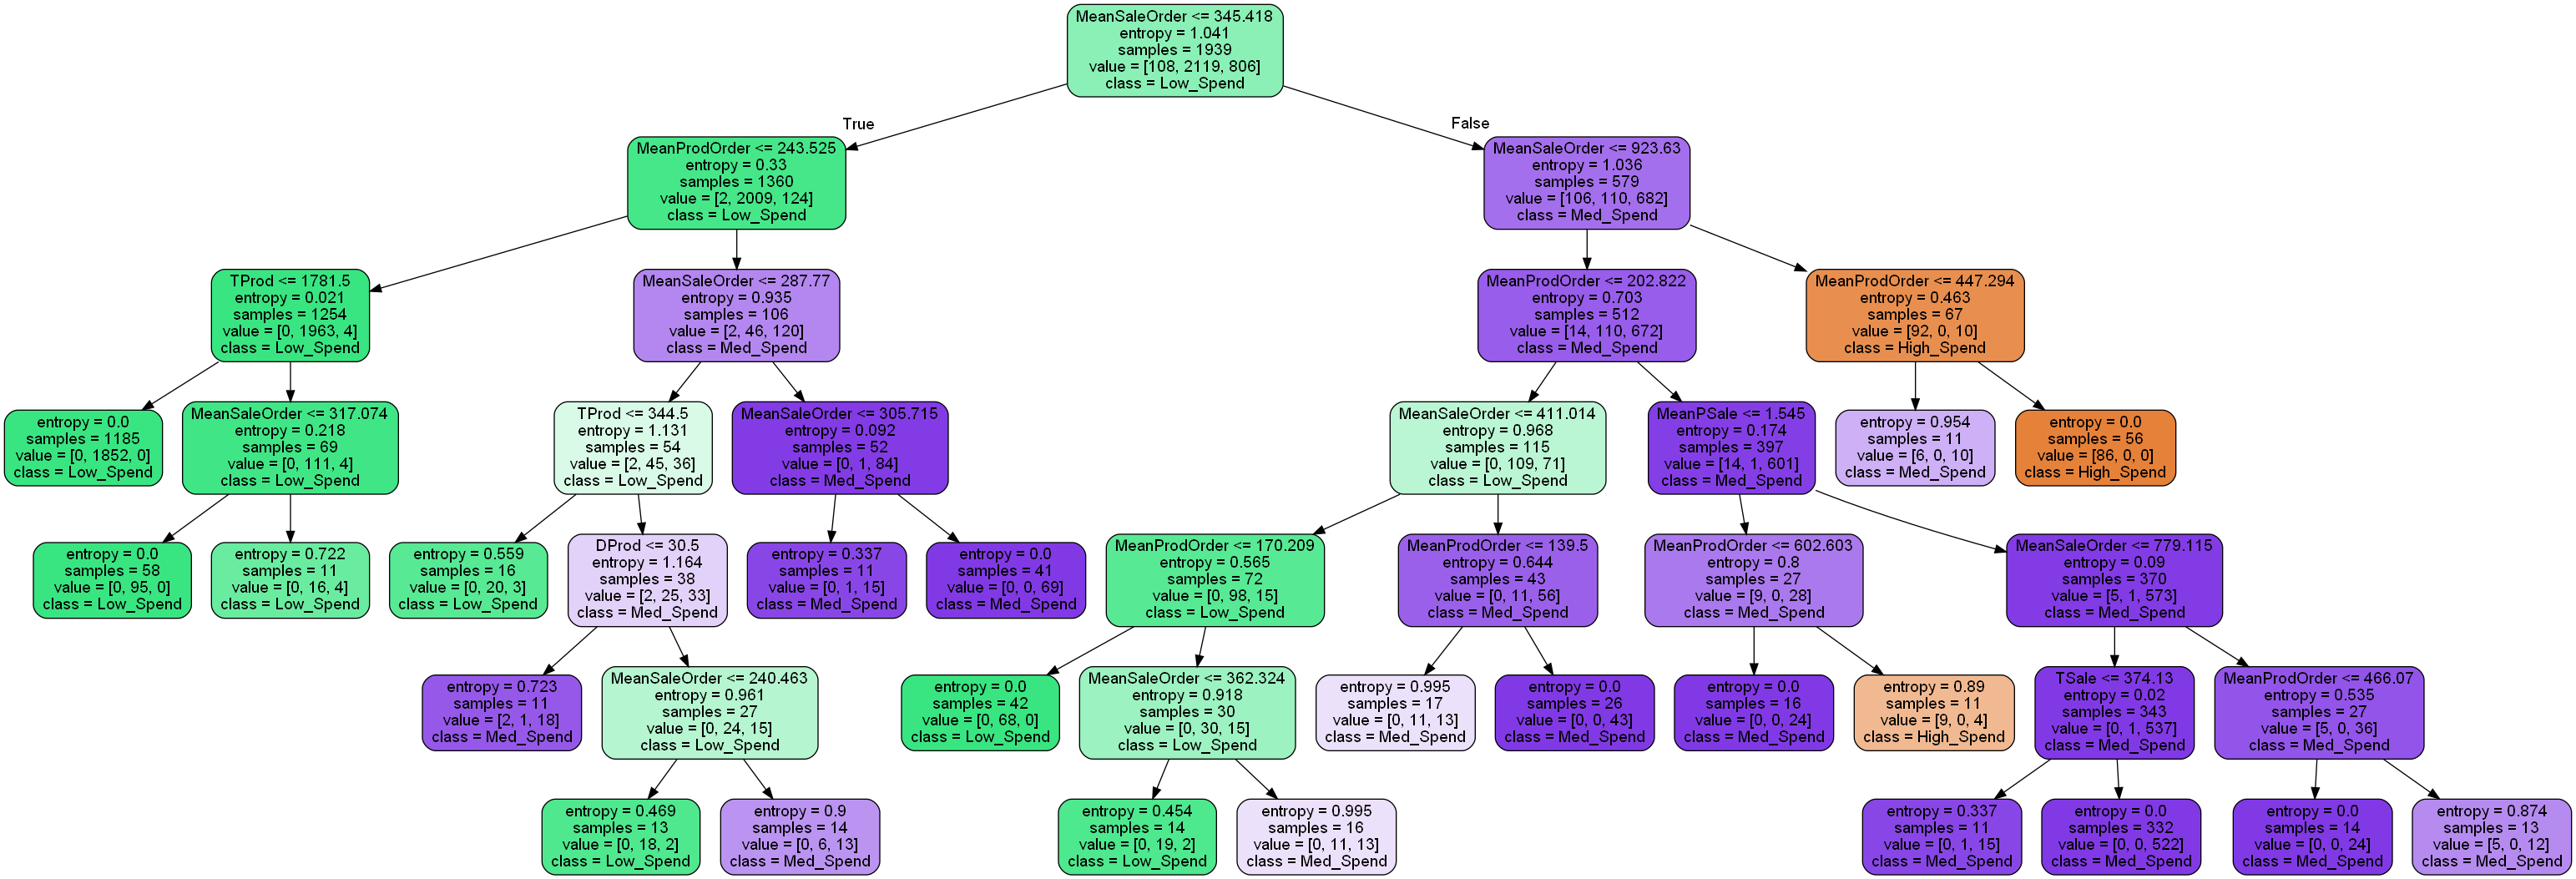

In [50]:
# forest is composed of lots of dt, visualize one just for fun
dot_data_f = tree.export_graphviz(rf_f[0], out_file=None, 
                         feature_names=list(train_set_f.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_f)  
Image(graph.create_png())

### Naive Bayes

In [51]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_f, train_label_f)

test_pred_gnb = gnb.predict(test_set_f)

report_scores(test_label_f,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.76      0.65      0.70        49
   Low_Spend       0.96      0.96      0.96       923
   Med_Spend       0.85      0.87      0.86       328

    accuracy                           0.93      1300
   macro avg       0.86      0.83      0.84      1300
weighted avg       0.93      0.93      0.93      1300



### KNN

In [52]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_f, train_label_f)

test_pred_knn = knn.predict(test_set_f)

report_scores(test_label_f,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.84      0.65      0.74        49
   Low_Spend       0.97      0.97      0.97       923
   Med_Spend       0.86      0.90      0.88       328

    accuracy                           0.94      1300
   macro avg       0.89      0.84      0.86      1300
weighted avg       0.94      0.94      0.94      1300



### SVM

In [53]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_f, train_label_f)

test_pred_svm_f = svm.predict(test_set_f)

report_scores(test_label_f, test_pred_svm_f)

              precision    recall  f1-score   support

  High_Spend       0.41      0.35      0.38        49
   Low_Spend       0.81      0.83      0.82       923
   Med_Spend       0.41      0.39      0.40       328

    accuracy                           0.70      1300
   macro avg       0.55      0.52      0.53      1300
weighted avg       0.69      0.70      0.70      1300



***

# Classification with Neural Network

### Preliminary functions
The following functions are useful in many sections of this notebook, therefore they
are put here at the beginning

Function to normalize the dataset:

In [54]:
def normalize_dataset(df):
    cols = df.columns
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df.values)
    df = pd.DataFrame(df, columns=cols)
    return df

Function to print the dataset's composition:

In [55]:
def print_dataset_composition(train_set, train_labels, test_set, test_labels):
    assert(len(train_set) == len(train_labels))
    assert(len(test_set) == len(test_labels))
    print(f"{len(train_labels)} training samples:")
    print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
    print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
    print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
    print(f"\n{len(test_labels)} test samples:")
    print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
    print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
    print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")

Function to create the NN model:

In [56]:
# Creates and returns a Keras NN model
def create_nn(size):
    """
    Characteristics:
        * 4 fully connected layers
            * the first 3 have 32 units
            * the last one has as many units as the number of classes, thus 3

        * activation function:
            * ReLU for the first 3 layers
            * Softmax for the output layer

        * Dropout of 0.2 is applied after every layer
    """
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(1,size)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

Function to compile and fit the NN model:

In [57]:
def compile_fit(model, training_set, training_labels, epochs):
    """
    Compile and fits the model

    :param training_labels:
    :param training_set:
    :param model: Keras NN model to train
    :return: history of training to plot the metrics
    """
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print(training_labels[0])
    hist = model.fit(
        training_set,
        training_labels,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    return hist

Function to plot the training results:

In [58]:
def plot_train_results(train_history):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro', label='Validation Loss')
    plt.title('Training and validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy & Loss')
    plt.legend()
    plt.grid()
    plt.show()

## Base dataframe
Labels come from _K-means_ clustering algorithm

In [59]:
# Drop categorical columns and keep only the corresponding numerical ones
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TProd              4333 non-null   int64  
 1   DProd              4333 non-null   int64  
 2   MeanProdOrder      4333 non-null   float64
 3   TSale              4333 non-null   float64
 4   MeanSaleOrder      4333 non-null   float64
 5   TRProd             4333 non-null   int64  
 6   MeanPSale          4333 non-null   float64
 7   TOrder             4333 non-null   int64  
 8   MeanTimeGap        4333 non-null   float64
 9   MaxOrderMonth_num  4333 non-null   int32  
 10  MaxOrderDay_num    4333 non-null   int32  
 11  Label_num          4333 non-null   int32  
dtypes: float64(5), int32(3), int64(4)
memory usage: 389.3 KB


In [60]:
# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df.pop('Label_num')

<AxesSubplot:>

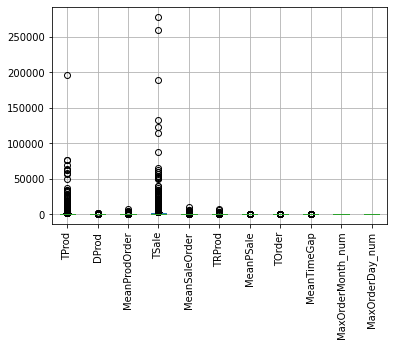

In [61]:
df.boxplot(rot=90)

Normalize the dataset

<AxesSubplot:>

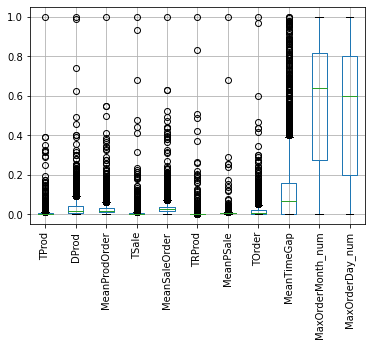

In [62]:
df = normalize_dataset(df)
df.boxplot(rot=90)

Divide the dataframe to create training and testing sets

In [63]:
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)
print_dataset_composition(train_set, train_labels, test_set, test_labels)

3033 training samples:
	- 18 samples for the class High_Spend
	- 2707 samples for the class Low_Spend
	- 308 samples for the class Med_Spend

1300 test samples:
	- 8 samples for the class High_Spend
	- 1160 samples for the class Low_Spend
	- 132 samples for the class Med_Spend


In [64]:
# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

Create the Neural Network, compile it and train it

In [65]:
nn = create_nn(len(df.columns))
history = compile_fit(nn, train_set, train_labels, epochs=20)

[0. 1. 0.]
Epoch 1/20
76/76 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.8500 - val_loss: 0.3919 - val_accuracy: 0.8979
Epoch 2/20
76/76 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8912 - val_loss: 0.3594 - val_accuracy: 0.8979
Epoch 3/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3739 - accuracy: 0.8912 - val_loss: 0.3446 - val_accuracy: 0.8979
Epoch 4/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8912 - val_loss: 0.3253 - val_accuracy: 0.8979
Epoch 5/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3335 - accuracy: 0.8912 - val_loss: 0.3018 - val_accuracy: 0.8979
Epoch 6/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3071 - accuracy: 0.8912 - val_loss: 0.2660 - val_accuracy: 0.8979
Epoch 7/20
76/76 [==============================] - 0s 2ms/step - loss: 0.2749 - accuracy: 0.8941 - val_loss: 0.2250 - val_accuracy: 0.9028
Epoch 8/2

Plot the training results:

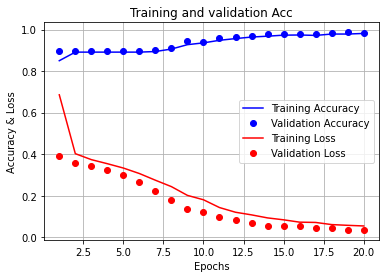

In [66]:
plot_train_results(history)

Test the model on the test set

In [67]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

  High_Spend       1.00      0.50      0.67         8
   Low_Spend       0.98      1.00      0.99      1160
   Med_Spend       0.96      0.83      0.89       132

   micro avg       0.98      0.98      0.98      1300
   macro avg       0.98      0.78      0.85      1300
weighted avg       0.98      0.98      0.98      1300
 samples avg       0.98      0.98      0.98      1300



## Base dataframe with SMOTE oversampling
Labels come from _K-Means_ clustering algorithm

### Normalize and SMOTE

In [68]:
#Normalize the dataset
cols = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df.values)
df = pd.DataFrame(df, columns=cols)

# Pick validation set from the complete df
df, val_set, labels, val_labels = train_test_split(df, labels, stratify=labels, test_size=0.5)

# SMOTE --> balance the number of entries of each class
smote = SMOTE(
    sampling_strategy='not majority',    # resample all classes but the majority one
    k_neighbors=5
)
df, labels = smote.fit_resample(df, labels)

# Divide the dataframe to create training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)

assert(len(train_set) == len(train_labels))
assert(len(val_set) == len(val_labels))
assert(len(test_set) == len(test_labels))
print(f"\n{len(train_labels)} training samples:")
print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} validation samples:")
print(f"\t- {len(val_labels[val_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(val_labels[val_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(val_labels[val_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} test samples:")
print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")

# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
val_labels = to_categorical(val_labels, 3)
test_labels = to_categorical(test_labels, 3)


4059 training samples:
	- 1353 samples for the class High_Spend
	- 1353 samples for the class Low_Spend
	- 1353 samples for the class Med_Spend

1740 validation samples:
	- 13 samples for the class High_Spend
	- 1934 samples for the class Low_Spend
	- 220 samples for the class Med_Spend

1740 test samples:
	- 580 samples for the class High_Spend
	- 580 samples for the class Low_Spend
	- 580 samples for the class Med_Spend


Create the Neural Network, compile it and train it

In [69]:
nn = Sequential([
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

nn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history = nn.fit(
    train_set,
    train_labels,
    epochs=27,
    batch_size=32,
    validation_data=(val_set, val_labels),
    verbose=1
)

Epoch 1/27

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

127/127 [==============================] - 0s 3ms/step - loss: 1.0620 - accuracy: 0.4210 - val_loss: 1.0499 - val_accuracy: 0.5745
Epoch 2/27
127/127 [==============================] - 0s 2ms/step - loss: 0.9154 - accuracy: 0.5474 - val_loss: 0.8700 - val_accuracy: 0.7116
Epoch 3/27
127/127 [==============================] - 0s 2ms/step - loss: 0.7363 - accuracy: 0.6324 - val_loss: 0.7188 - val_accuracy: 0.8482
Epoch 4/27
127/127 [==============================] - 0s 2ms/step - loss: 0.6429 -

Plot the training results:

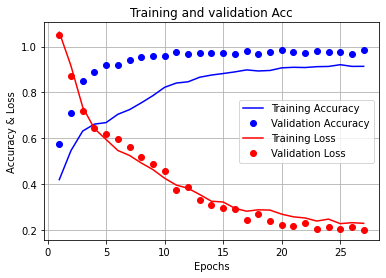

In [70]:
plot_train_results(history)

Test the model on the test set

In [71]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)


              precision    recall  f1-score   support

  High_Spend       1.00      1.00      1.00       580
   Low_Spend       1.00      0.99      0.99       580
   Med_Spend       0.99      1.00      0.99       580

   micro avg       1.00      1.00      1.00      1740
   macro avg       1.00      1.00      1.00      1740
weighted avg       1.00      1.00      1.00      1740
 samples avg       1.00      1.00      1.00      1740



## Dataframe coming from Fuzzy C-Means
Labels come from _Fuzzy C-Means_ clustering algorithm

In [72]:
# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df_f.pop('Label_num')

#Normalize the dataset
df_f = normalize_dataset(df_f)

# Divide the dataframe to create training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df_f, labels, stratify=labels, test_size=0.30)
print_dataset_composition(train_set, train_labels, test_set, test_labels)

# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

3033 training samples:
	- 113 samples for the class High_Spend
	- 2155 samples for the class Low_Spend
	- 765 samples for the class Med_Spend

1300 test samples:
	- 49 samples for the class High_Spend
	- 923 samples for the class Low_Spend
	- 328 samples for the class Med_Spend


Create the Neural Network, compile it and train it

In [73]:
nn = create_nn(len(df_f.columns))
history = compile_fit(nn, train_set, train_labels, epochs=20)

[0. 1. 0.]
Epoch 1/20
76/76 [==============================] - 0s 4ms/step - loss: 0.9659 - accuracy: 0.6002 - val_loss: 0.7394 - val_accuracy: 0.7150
Epoch 2/20
76/76 [==============================] - 0s 2ms/step - loss: 0.7376 - accuracy: 0.7094 - val_loss: 0.6932 - val_accuracy: 0.7150
Epoch 3/20
76/76 [==============================] - 0s 2ms/step - loss: 0.7160 - accuracy: 0.7094 - val_loss: 0.6736 - val_accuracy: 0.7150
Epoch 4/20
76/76 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.7090 - val_loss: 0.6448 - val_accuracy: 0.7150
Epoch 5/20
76/76 [==============================] - 0s 2ms/step - loss: 0.6556 - accuracy: 0.7098 - val_loss: 0.5928 - val_accuracy: 0.7216
Epoch 6/20
76/76 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.7267 - val_loss: 0.5243 - val_accuracy: 0.7331
Epoch 7/20
76/76 [==============================] - 0s 2ms/step - loss: 0.5268 - accuracy: 0.7593 - val_loss: 0.4442 - val_accuracy: 0.7710
Epoch 8/2

Plot the training results:

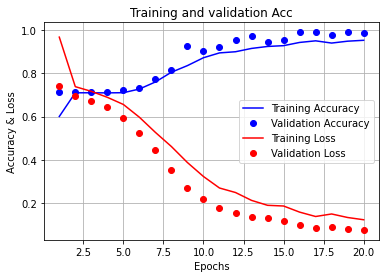

In [74]:
plot_train_results(history)

Test the model on the test set

In [75]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

              precision    recall  f1-score   support

  High_Spend       1.00      0.78      0.87        49
   Low_Spend       1.00      0.98      0.99       923
   Med_Spend       0.92      0.99      0.95       328

   micro avg       0.98      0.98      0.98      1300
   macro avg       0.97      0.91      0.94      1300
weighted avg       0.98      0.98      0.98      1300
 samples avg       0.98      0.98      0.98      1300



# Alternative Features

For this analysis the dataset *customer_dataframe_big.csv* will be used, since it contains all the features for the customers.
Then, joining with the dataset created from Fuzzy K-Means we add the labeling to the various customers.   

In [76]:
df = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)
df_customer = pd.read_csv('datasets/customer_dataframe_big.csv', sep='\t', index_col=0)

df_customer.set_index("CustomerID", inplace = True)
df_customer['Label'] = df['Label']

# Size of different classes in the dataset
print("-------------------------")
for i in ['Low_Spend', 'Med_Spend', 'High_Spend']:
    print(i, len(df_customer[df_customer['Label'] == i]))

-------------------------
Low_Spend 3078
Med_Spend 1093
High_Spend 162


The target of this analysis is to use all the features that are not exploited by the clustering to assign the customers to a class.

In [77]:
# Drop all the features that are not time dependent and not usefull to generalize the behaviour of a customer
df_customer = discretize_data(df_customer,['MaxOrderMonth','Label'])
df_aux = df_customer.drop(columns=['TProd', 'MaxPO', 'MinPO', 'MeanProdOrder', 'TSaleWRet', 'MinPSale', 'MaxPSale', 'MeanSaleOrder',
                                   'MeanPSale', 'MaxOrderMonth', 'MaxOrderMonth', 'MaxOrderDay', 'Label', 'TRProd', 
                                   'SETSaleQta', 'SESaleQtaOrder', 'SEShoppingDays', 'DProd', 'TSale', 'TOrder'], errors='ignore')
df_class = df_aux.copy()
df_class.tail()

,OrderMonth,ProdMonth,SaleMonth,MonthPresence,MeanTimeGap,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,
13436,0.083,6.333,16.407,0.083,0.0,2,1
15520,0.083,26.167,28.625,0.083,0.0,2,2
13298,0.083,8.000,30.000,0.083,0.0,2,1
14569,0.083,6.583,18.949,0.083,0.0,2,1
12713,0.083,42.083,66.212,0.083,0.0,2,2


# Decision Tree

In [78]:
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.35)
print(f"Class HighSpend\nTraining: {len(train_label[train_label == 0])}\nTest: {len(test_label[test_label == 0])}")

Class HighSpend
Training: 105
Test: 57


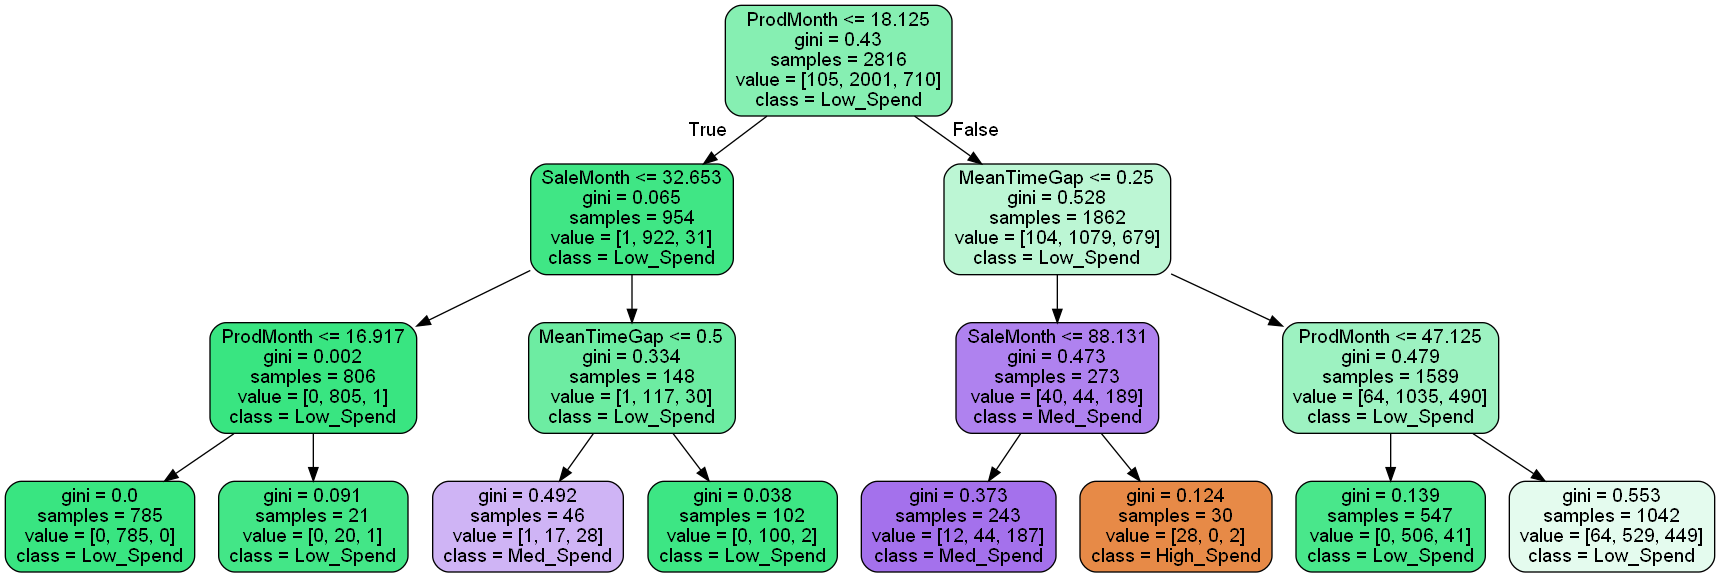

In [79]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=17, min_samples_leaf=20)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [80]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.92      0.40      0.56        57
   Low_Spend       0.78      0.97      0.86      1077
   Med_Spend       0.77      0.31      0.44       383

    accuracy                           0.78      1517
   macro avg       0.82      0.56      0.62      1517
weighted avg       0.78      0.78      0.75      1517



***